# Figure 4

This notebook recreates the figure panels included in Figure 4 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 




## Preparing the Data
### Importing required code packages and modules

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import utils.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

Missing colon in file '/Users/sasha/.matplotlib/matplotlibrc', line 1 ('~/.matplotlib/matplotlibrc')


### downloading data

In [2]:
load_prefix = '../../data/logs/VA_maze/'

with open(load_prefix + '5000t_mosttrain_nova_db.p', 'rb') as f:
     [actions_, rewards_, feats_, terms_, vs_, tow_counts_, episode_lengths, _]  = pickle.load(f)
f.close()

with open(load_prefix + '1000t_obses_nova_db.p', 'rb') as f:
     obses_  = pickle.load(f)[0]
f.close()

trial_info = loadmat(load_prefix + 'trialinfo_nova_db.mat')['trials']
raw_ypos_ = [x[:,1] for x in trial_info['position'][0]]

# observations from an empty run thru of the maze
obses_empty  = loadmat(load_prefix + 'emptymaze_runthru.mat')['obses']
ypos_obses  = loadmat(load_prefix + 'emptymaze_runthru.mat')['ypos']




### Plotting Parameters

In [3]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

### Organizing Data

Pulling out the specific data that we will use for figure panels

In [4]:
CUEP_LIM = 140

autocorr_start = 2
autocorr_end = -35

CUEP_LIM = 140
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in raw_ypos_])[:,:,0])

obses_empty_flat = obses_empty[:, :,:140].T.reshape((140, 68 * 120))


### Calculate Vector RPEs

In [5]:
if os.path.exists(load_prefix + 'no_va/pes_nova_db.p'):

    with open(load_prefix + 'no_va/pes_nova_db.p', 'rb') as f:
         pes  = pickle.load(f)
    f.close()
else: 
    weights = utils.get_params_from_zip(load_prefix + 'rl_model_20800000_steps')
    w_val = np.squeeze(weights['model/vf/w:0'])

    feats = np.vstack(feats_)
    rewards = np.hstack(rewards_)
    terms = np.hstack(terms_)
    start = np.roll(terms,1)
    nsteps = len(terms)
    nfeatures = feats_[0][0].shape[0]
    gamma = 0.99
    # compute per-feature PEs
    pes = np.zeros((nsteps, nfeatures))
    for i in range(0,nsteps-1):
        if (terms[i]): # there is a one-off error-- the SECOND index of the start of the trial accurately measures the start of the trial
            pes[i,:] = rewards[i] / nfeatures -  w_val * feats[i,:]
        else:
            pes[i,:] = rewards[i] / nfeatures +  w_val * (-feats[i,:] + gamma * feats[i+1,:])

    pickle.dump(pes, open(load_prefix + "pes_nova_db.p", "wb") )


    
# pes split by 5000 trials
pes_ = utils.split_by_ep_len(pes, np.hstack((episode_lengths)))

pes_cuep = np.dstack([pes_i[:CUEP_LIM,:] for pes_i in pes_])

In [6]:
# helper functions (to put in a different file)

def plot_frame(frame_i, vmin=None,vmax=None):
    if vmin is None:
        vmin = np.min(frame_i)
        vmax = np.max(frame_i)
    plt.imshow(obses_trial[:,:,frame_i], cmap = 'viridis', vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    
"""
autocorr calculates mean-corrected cos angle across time of a matrix as a measure of similarity
        each timestep's vector is mean-corrected, then normalized to length 1, then dot producted to itself
inputs> mat: matrix with ROWS of observations across time.(so timesteps x shape)
"""
def covar_mat(mat):

    mat_meancorr = np.vstack([mat_i - np.mean(mat_i) for mat_i in mat])
    mat_norm = np.sqrt(np.diag(mat_meancorr.dot(mat_meancorr.T)))
    return (mat_meancorr/mat_norm[:, None]).dot((mat_meancorr/mat_norm[:, None]).T)



In [7]:
# helper functions  for 1D plots 

def align_ac(mat, shift_order): return np.vstack(
    [np.roll(mat[i, :], shift=-shift_i) for (i, shift_i) in enumerate(shift_order)])


def get_align_nowrap(mat, shift_order):
    padded_mat = np.hstack([np.full(mat.shape, np.nan), mat])
    aligned_mat = align_ac(padded_mat, shift_order)

    return aligned_mat


def get_1D_by_lag(mat, shift_order):
    aligned_mat = get_align_nowrap(mat, shift_order)

    return np.nanmean(aligned_mat, 0)[2:-1]


def plot_1D(aligned_1D):
    ypos_clipped = ypos_cuep[autocorr_start+1:autocorr_end-1]
    plt.plot(np.sort(-ypos_clipped), aligned_1D[:101], 'C0')
    plt.plot(ypos_clipped, aligned_1D[102:], 'C0')



## Figure 4A: Similarity of Video Frames

In [11]:
TEXTURE_REPEAT_IDX = 67

obses_trial = obses_empty[:,:,:140]
vmin = np.min(np.hstack([obses_trial[:,:,120], obses_trial[:,:,0]]))
vmax = np.max(np.hstack([obses_trial[:,:,120], obses_trial[:,:,0]]))


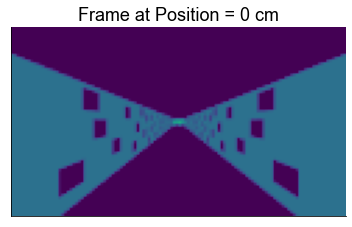

In [13]:
plot_frame(0, vmin, vmax)
plt.title('Frame at Position = 0 cm');

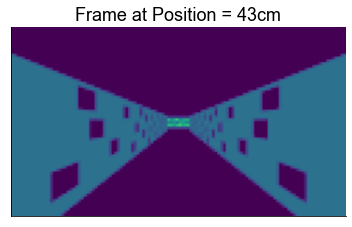

In [14]:
plot_frame(TEXTURE_REPEAT_IDX, vmin, vmax)
plt.title('Frame at Position = ' + str(round(ypos_cuep[TEXTURE_REPEAT_IDX])) + 'cm');


In [9]:
obses_ac = covar_mat(obses_empty_flat)
obses_ac_lim = obses_ac[autocorr_start:autocorr_end, autocorr_start:autocorr_end]


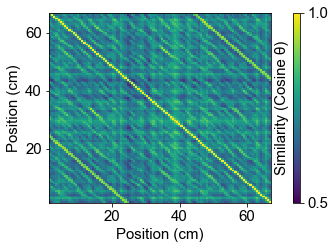

In [16]:
fig, ax = plt.subplots(1,2, figsize =(4.5, 3.5), gridspec_kw=dict(width_ratios=[1,0.03]))
im = ax[0].imshow(obses_ac_lim, aspect = 'auto',
                extent = [ypos_cuep[autocorr_start], ypos_cuep[autocorr_end], ypos_cuep[autocorr_start], ypos_cuep[autocorr_end]],
                cmap = 'viridis',  interpolation = 'none')

ax[0].set_yticks([20, 40, 60])
ax[0].set_xticks([20, 40, 60])
im.set_clim(0.5,1) # min is at 0.544, clim to ensure colorbar has 0.5 tick
cbar = fig.colorbar(im, cax = ax[1], ticks = [-1, 0, 0.5, 1])
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('Similarity (Cosine θ)')


ax[0].spines['right'].set_visible(True)
ax[0].spines['top'].set_visible(True)

ax[0].set_xlabel('Position (cm)');
ax[0].set_ylabel('Position (cm)');

## Figure 4B: Averaged Cos-angle

/Users/sasha/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


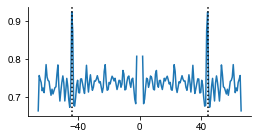

In [12]:
obses_ac_1D = get_1D_by_lag(obses_ac_lim, np.arange(103))

# plt.plot(np.hstack([np.arange(103), np.arange(-102, 1)]),np.nanmean(obses_ac_lim_align2,0))
plt.figure(figsize=(4, 2))
plot_1D(obses_ac_1D)
# plt.title('Observation Autocorrelation 1D')
# plt.xlabel('Lag')
plt.xticks([-40, 0, 40])
plt.axvline(-ypos_cuep[TEXTURE_REPEAT_IDX + autocorr_start], color='k', ls=':')
plt.axvline(ypos_cuep[TEXTURE_REPEAT_IDX + autocorr_start], color='k', ls=':')

## Figure 4C: Similarity of Vector RPEs

In [13]:
pes_ac = covar_mat(np.mean(pes_cuep, -1))
pes_ac_lim = pes_ac[autocorr_start:autocorr_end, autocorr_start:autocorr_end]


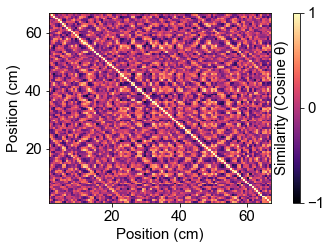

In [18]:
fig, ax = plt.subplots(1,2, figsize =(4.5, 3.5), gridspec_kw=dict(width_ratios=[1,0.03]))
im = ax[0].imshow(pes_ac_lim, aspect = 'auto',
                extent = [ypos_cuep[autocorr_start], ypos_cuep[autocorr_end], ypos_cuep[autocorr_start], ypos_cuep[autocorr_end]],
                cmap = 'magma',  interpolation = 'none')
ax[0].set_xticks([20, 40, 60])
im.set_clim(-1,1)
ax[0].spines['right'].set_visible(True)
ax[0].spines['top'].set_visible(True)
cbar = fig.colorbar(im, cax = ax[1], ticks = [-1, 0, 1])
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('Similarity (Cosine θ)')

ax[0].set_xlabel('Position (cm)');
ax[0].set_ylabel('Position (cm)');

### Figure 4D

/Users/sasha/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


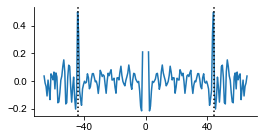

In [14]:
pes_ac_1D = get_1D_by_lag(pes_ac_lim, np.arange(103))

# plt.plot(np.hstack([np.arange(103), np.arange(-102, 1)]),np.nanmean(obses_ac_lim_align2,0))
plt.figure(figsize=(4, 2))
plot_1D(pes_ac_1D)
# plt.title('Observation Autocorrelation 1D')
# plt.xlabel('Lag')
plt.xticks([-40, 0, 40])
plt.axvline(-ypos_cuep[TEXTURE_REPEAT_IDX + autocorr_start], color='k', ls=':')
plt.axvline(ypos_cuep[TEXTURE_REPEAT_IDX + autocorr_start], color='k', ls=':')